# Foundations of Logistic Regression

In [1]:
# Import library
import os

# Change the working directory
os.chdir('files')

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [3]:
# Random pi parameter

pi = np.random.random()

print(pi)

0.2619957124986344


#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

In [4]:
# Sample size
n = 100
# Discrete random variables from the bernoulli distribution with pi = probability and size = 100
bernoulli_samples = bernoulli.rvs(pi, size=n)

#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

([<matplotlib.axis.XTick at 0x2c2124d2440>,
 [Text(0.15, 0, 'Left'), Text(0.85, 0, 'Right')])

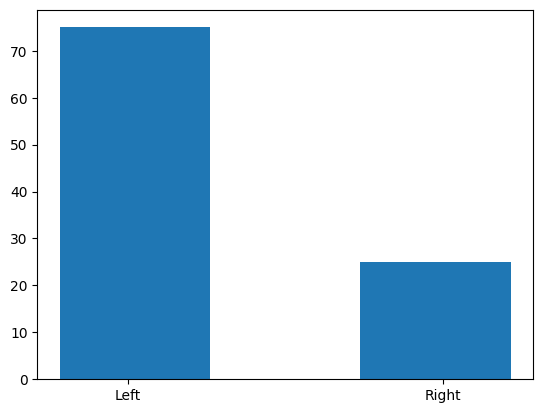

In [5]:
plt.hist(bernoulli_samples, bins = 3)
plt.xticks([0.15, 0.85], ['Left', 'Right'])

#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [6]:
calculated_pi = np.mean(bernoulli_samples)
print(pi)

0.2619957124986344


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: 

Uncertainty could be due to sampling variability, irreducible variability, and sample size

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

Estimated Variance of Pi: 0.001875


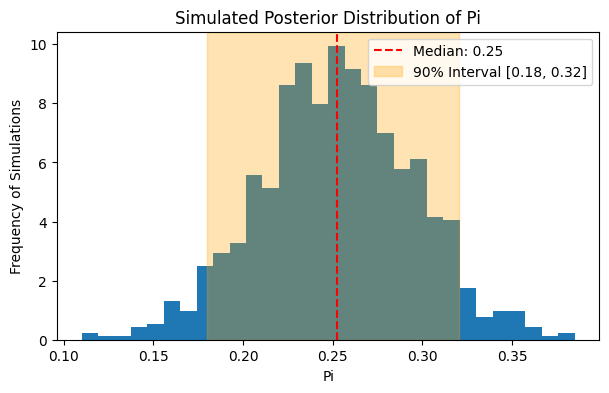

In [7]:
# The Normal approximation of the posterior

# Calculate the estimated variance for pi
hat_var_pi = calculated_pi * (1 - calculated_pi) / n
print(f"Estimated Variance of Pi: {hat_var_pi}")

# Draw simulated values from the Normal posterior
pi_sims = np.random.normal(calculated_pi,np.sqrt(hat_var_pi),1000)

# Calculate the median and the 90% interval
median_pi = np.median(pi_sims)
lower_bound, upper_bound = np.percentile(pi_sims, [5, 95])

# Plot the simulated values
plt.figure(figsize=(7, 4))
plt.hist(pi_sims, bins=30, density=True)
plt.title('Simulated Posterior Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency of Simulations')

# Add annotations for median and 90% interval
plt.axvline(median_pi, color='r', linestyle='--', label=f'Median: {median_pi:.2f}')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'90% Interval [{lower_bound:.2f}, {upper_bound:.2f}]')
plt.legend()

plt.show()


#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

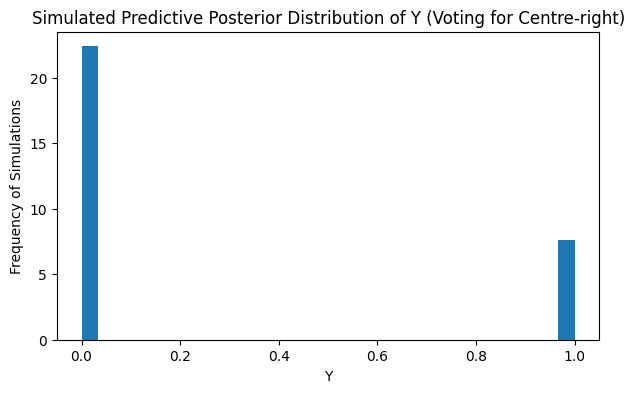

In [8]:
# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
#get rid of values that are not between 0 and 1
pi_sims = np.clip(pi_sims, 0, 1)
for pi in pi_sims:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

# Convert the list to a numpy array
post_pred_sims = np.array(post_pred_sims)

# Plot the simulated values
plt.figure(figsize=(7, 4))
plt.hist(post_pred_sims, bins=30, density=True)
plt.title('Simulated Predictive Posterior Distribution of Y (Voting for Centre-right)')
plt.xlabel('Y')
plt.ylabel('Frequency of Simulations')

plt.show()

The voters are most likely to be voting for centre-right

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

DATASET: https://www.kaggle.com/datasets/missionjee/car-sales-report

In [9]:
# Read csv file
df = pd.read_csv('car_data.csv')

# Check dataset size
print(df.shape)

(23906, 16)


In [10]:
# Display dataframe
df.head(10)

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville
5,C_CND_000006,1/2/2022,Guadalupe,Male,850000,Classic Chevy,Mitsubishi,Diamante,Overhead Camshaft,Manual,Pale White,12000,85257-3102,Hatchback,7315216,Scottsdale
6,C_CND_000007,1/2/2022,Hailey,Male,1600000,Clay Johnson Auto Sales,Toyota,Corolla,Overhead Camshaft,Manual,Pale White,14000,78758-7841,Passenger,7727879,Austin
7,C_CND_000008,1/2/2022,Graham,Male,13500,U-Haul CO,Mitsubishi,Galant,DoubleÂ Overhead Camshaft,Auto,Pale White,42000,78758-7841,Passenger,6206512,Austin
8,C_CND_000009,1/2/2022,Naomi,Male,815000,Rabun Used Car Sales,Chevrolet,Malibu,Overhead Camshaft,Manual,Pale White,82000,85257-3102,Hardtop,7194857,Pasco
9,C_CND_000010,1/2/2022,Grayson,Female,13500,Rabun Used Car Sales,Ford,Escort,DoubleÂ Overhead Camshaft,Auto,Pale White,15000,85257-3102,Passenger,7836892,Scottsdale


In [11]:
# Clean dataset; get rid off unused columns and drop NAN
df = df[['Gender','Annual Income', 'Company', 'Transmission','Color','Body Style']]
df = df.dropna()

display(df)

,Gender,Annual Income,Company,Transmission,Color,Body Style
0,Male,13500,Ford,Auto,Black,SUV
1,Male,1480000,Dodge,Auto,Black,SUV
2,Male,1035000,Cadillac,Manual,Red,Passenger
3,Male,13500,Toyota,Manual,Pale White,SUV
4,Male,1465000,Acura,Auto,Red,Hatchback
...,...,...,...,...,...,...
23901,Male,13500,Plymouth,Manual,Red,Passenger
23902,Female,900000,Chevrolet,Auto,Black,Hardtop
23903,Male,705000,BMW,Manual,Red,Sedan
23904,Male,13500,Chevrolet,Auto,Black,Passenger


In [12]:
# Change gender to binary outcomes in a new column
df['gender-binary'] = np.where(df['Gender'] == 'Female', 1, 0)

# Define Y
Y = df['gender-binary']

#### d) Create a design matrix 

In [13]:
# StandardScaler
scaler = StandardScaler()

# Transform categorical variables to matrix 
company = pd.get_dummies(df['Company'])
color = pd.get_dummies(df['Color'])

# Merge categorical variables
X_cat = pd.concat([company, color], axis = 1)
X_cat = X_cat.astype(int)

# Standarise numerical values
X_num = scaler.fit_transform(df['Annual Income'].values.reshape(-1,1))
X_num = pd.DataFrame(X_num, columns = ['Annual income'])

# Merge numerical and categorical variables
X = pd.concat([X_cat, X_num], axis = 1)

print(X.head())

   Acura  Audi  BMW  Buick  Cadillac  Chevrolet  Chrysler  Dodge  Ford  Honda  \
0      0     0    0      0         0          0         0      0     1      0   
1      0     0    0      0         0          0         0      1     0      0   
2      0     0    0      0         1          0         0      0     0      0   
3      0     0    0      0         0          0         0      0     0      0   
4      1     0    0      0         0          0         0      0     0      0   

   ...  Saab  Saturn  Subaru  Toyota  Volkswagen  Volvo  Black  Pale White  \
0  ...     0       0       0       0           0      0      1           0   
1  ...     0       0       0       0           0      0      1           0   
2  ...     0       0       0       0           0      0      0           0   
3  ...     0       0       0       1           0      0      0           1   
4  ...     0       0       0       0           0      0      0           0   

   Red  Annual income  
0    0      -1.13520

#### e) Correlation matrix

In [14]:
# Stack Y and X and get rid off nan values
YX = np.hstack((np.array(Y)[:, np.newaxis], X))
YX = YX[~np.any(np.isnan(YX), axis=1)]

np.corrcoef(YX.T)

array([[ 1.00000000e+00,  1.20660800e-02, -1.03109293e-02, ...,
         8.77668207e-03, -4.36409761e-03, -5.42043714e-02],
       [ 1.20660800e-02,  1.00000000e+00, -2.43427261e-02, ...,
        -4.82932345e-02,  2.42676597e-02, -4.88342268e-03],
       [-1.03109293e-02, -2.43427261e-02,  1.00000000e+00, ...,
        -9.28833457e-03, -6.54832756e-02, -2.19511931e-03],
       ...,
       [ 8.77668207e-03, -4.82932345e-02, -9.28833457e-03, ...,
         1.00000000e+00, -4.72374085e-01,  8.26648780e-04],
       [-4.36409761e-03,  2.42676597e-02, -6.54832756e-02, ...,
        -4.72374085e-01,  1.00000000e+00, -3.17117387e-03],
       [-5.42043714e-02, -4.88342268e-03, -2.19511931e-03, ...,
         8.26648780e-04, -3.17117387e-03,  1.00000000e+00]])

There is a diagonal of 1s, that means those variables are strongly correlated, due to the fact the correlation i between the same variables e.g. outcome vs outcome.

#### f) Fit the logistic regression.

In [15]:
# Get labels
labels = X.columns

# Define independent variable
Y = YX[:,0]

# Define dependent variable
X = pd.DataFrame(YX[:,1:], columns= labels)  
X_with_intercept = sm.add_constant(X)

# Fit model
model = sm.Logit(Y, X_with_intercept).fit()

         Current function value: 0.516424
         Iterations: 35


c:\Users\majak\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23906
Model:                          Logit   Df Residuals:                    23872
Method:                           MLE   Df Model:                           33
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                0.004539
Time:                        11:06:10   Log-Likelihood:                -12346.
converged:                      False   LL-Null:                       -12402.
Covariance Type:            nonrobust   LLR p-value:                 1.276e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9788   3.21e+06  -3.05e-07      1.000   -6.28e+06    6.28e+06
Acura             0.1562   5.18e+06   3.02e-08      1.000   -1.01e+07    1.01e+07
Audi             -0.1993   5.18e+06  -3.

#### h) Empirical posterior distribution.

In [17]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression model
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean = beta_mean, cov = beta_cov, size = n_simulations)

c:\Users\majak\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:758: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

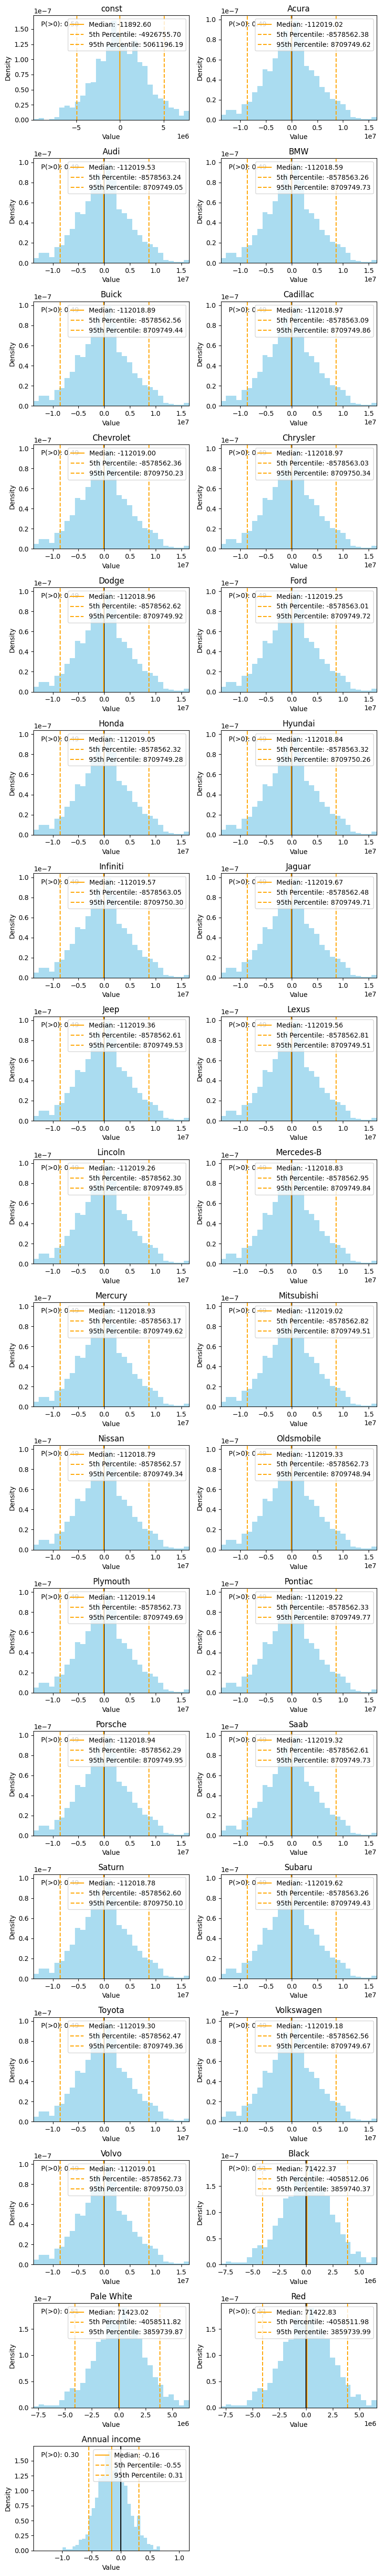

In [18]:
# Medians, intervals, and probabilities of being positive
medians = np.median(simulated_betas, axis = 0)
lower_quantiles = np.percentile(simulated_betas, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas, 95, axis=0)
prob_positive = np.mean(simulated_betas > 0, axis=0)

num_coeffs = simulated_betas.shape[1]

# Plot histograms of each coefficient
num_rows = (num_coeffs + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(8,num_rows*3))
axs = axs.flatten()

for i in range(num_coeffs):
    ax = axs[i]
    ax.hist(simulated_betas[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_with_intercept.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim(left=min(simulated_betas[:, i]) - 0.5, right=max(simulated_betas[:, i]) + 0.5)
    
# Hide empty subplot
if num_coeffs % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


All of the simulated betas, excpet for the anuual income variable, have a high variance. That means that there is a big uncertainty about those parameters. To compare effect sizes, the model should be standarised, meaning the mean of 0 and standard deviation of 1.

#### i) Predictions

In [19]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(np.dot(simulated_betas, average_X))

#### l) Generate values from the posterior predictive distribution of the outcome Y 

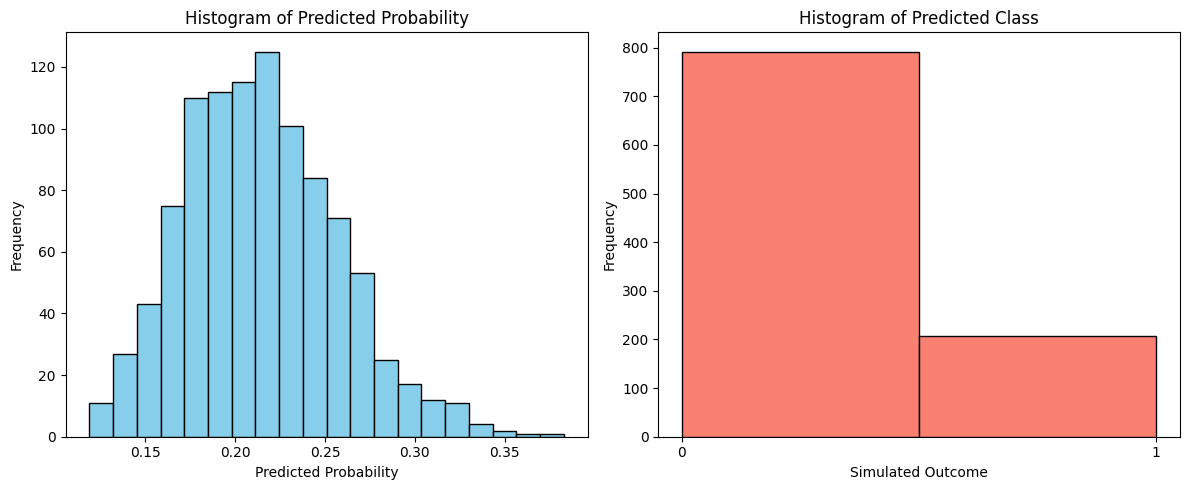

In [20]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = np.random.binomial(1, new_predicted_probs)

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
